In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB4
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

**Base Model | EfficientNetB4**

In [ ]:
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Data/')

Mounted at /content/drive/


In [ ]:
y = np.expand_dims(img1, axis=-1)
print(y.shape)


(128, 128, 1)


In [ ]:
def visualise_image(index, images_list=X_train, masks_list=ytrain):
    f = plt.figure()
    f.add_subplot(1, 3, 1)
    plt.imshow(images_list[index])
    f.add_subplot(1, 3, 2)
    plt.imshow(masks_list[index])
    f.add_subplot(1, 3, 3)
    img = model.predict(np.expand_dims(images_list[index], axis=0)).reshape(224, 224,1)
    img = np.where(img  > 0.5, img , 0)
    plt.imshow(img)

In [ ]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=128

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)


for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)

# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 224/224 [00:03<00:00, 58.69it/s] 


In [ ]:
Ytrain.shape

(5761,)

In [ ]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

In [ ]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.1, random_state=42)

In [ ]:
xtrain.shape

(5184, 128, 128, 3)

In [ ]:
Ytrain

array(['Non_Demented', 'Non_Demented', 'Non_Demented', ...,
       'Very_Mild_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented'],
      dtype='<U18')

In [ ]:
xtest.shape

(577, 128, 128, 3)

In [ ]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e

ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [ ]:
ytrain.shape

(5184, 4)

In [ ]:
ytest.shape

(577, 4)

In [ ]:
efficientnetB4= EfficientNetB4(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

71686520/71686520 [==============================] - 3s 0us/step


In [ ]:
# Output of model

model = efficientnetB4.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB4.input, outputs=model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
filepath = './inception_v4.hdf5'

In [ ]:
tf.keras.callbacks.ModelCheckpoint(
filepath,
monitor = 'val_loss',
verbose = 0,
save_best_only  = False,
save_weights_only = False,
mode = 'auto',
save_freq='epoch',
options=None,
initial_value_threshold=None
 )

In [ ]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficientNetB4.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                            min_delta=0.001)

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr])

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.8768 - accuracy: 0.6126

146/146 [==============================] - 142s 251ms/step - loss: 0.8768 - accuracy: 0.6126 - val_loss: 2.7890 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.8234

146/146 [==============================] - 32s 219ms/step - loss: 0.4573 - accuracy: 0.8234 - val_loss: 0.7640 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9128

146/146 [==============================] - 32s 222ms/step - loss: 0.2424 - accuracy: 0.9128 - val_loss: 0.5742 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9402

146/146 [==============================] - 33s 223ms/step - loss: 0.1757 - accuracy: 0.9402 - val_loss: 0.4330 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9674

146/146 [==============================] - 33s 225ms/step - loss: 0.0983 - accuracy: 0.9674 - val_loss: 0.0832 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9775

146/146 [==============================] - 33s 226ms/step - loss: 0.0638 - accuracy: 0.9775 - val_loss: 0.1493 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 7/20
146/146 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9743

146/146 [==============================] - 33s 226ms/step - loss: 0.0769 - accuracy: 0.9743 - val_loss: 0.1489 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 8/20
146/146 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9816

146/146 [==============================] - 33s 227ms/step - loss: 0.0506 - accuracy: 0.9816 - val_loss: 0.1653 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 9/20
146/146 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9878

146/146 [==============================] - 33s 226ms/step - loss: 0.0340 - accuracy: 0.9878 - val_loss: 0.1874 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 10/20
146/146 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9771

146/146 [==============================] - 33s 226ms/step - loss: 0.0660 - accuracy: 0.9771 - val_loss: 0.0879 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 11/20
146/146 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9908

146/146 [==============================] - 33s 227ms/step - loss: 0.0290 - accuracy: 0.9908 - val_loss: 0.6075 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 12/20
146/146 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9852

146/146 [==============================] - 33s 226ms/step - loss: 0.0450 - accuracy: 0.9852 - val_loss: 0.0572 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 13/20
146/146 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9899

146/146 [==============================] - 33s 226ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 0.1379 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 14/20
146/146 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9835

146/146 [==============================] - 33s 226ms/step - loss: 0.0477 - accuracy: 0.9835 - val_loss: 0.2839 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 15/20
146/146 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9863

146/146 [==============================] - 33s 226ms/step - loss: 0.0447 - accuracy: 0.9863 - val_loss: 0.1897 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 16/20
146/146 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9854

146/146 [==============================] - 33s 226ms/step - loss: 0.0433 - accuracy: 0.9854 - val_loss: 0.1205 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 17/20
146/146 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9835

146/146 [==============================] - 33s 226ms/step - loss: 0.0439 - accuracy: 0.9835 - val_loss: 0.5664 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 18/20
146/146 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9908

146/146 [==============================] - 33s 226ms/step - loss: 0.0279 - accuracy: 0.9908 - val_loss: 0.1005 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 19/20
146/146 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9921

146/146 [==============================] - 33s 227ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.1145 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 20/20
146/146 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9882

146/146 [==============================] - 33s 226ms/step - loss: 0.0319 - accuracy: 0.9882 - val_loss: 0.1991 - val_accuracy: 0.9441 - lr: 0.0010


In [ ]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

19/19 [==============================] - 4s 85ms/step
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        81
           1       1.00      1.00      1.00         8
           2       1.00      0.95      0.98       291
           3       0.90      0.99      0.94       197

    accuracy                           0.96       577
   macro avg       0.96      0.96      0.96       577
weighted avg       0.96      0.96      0.96       577



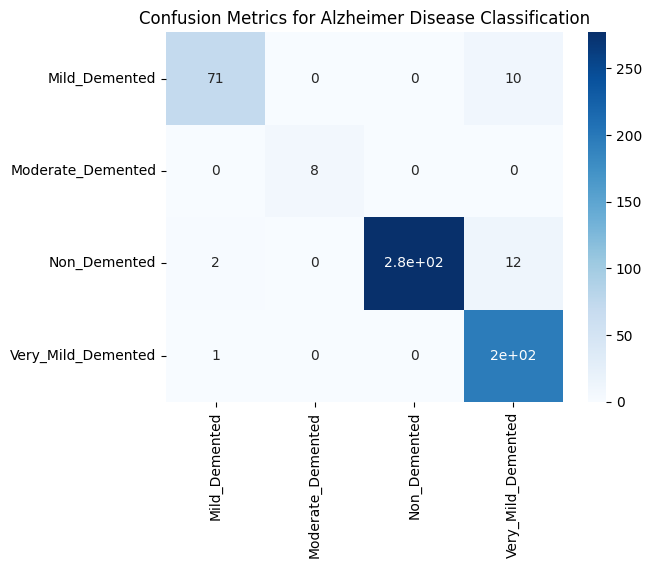

In [ ]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification")
plt.show()

In [ ]:
def accuracy_and_loss_Plot(modelData):

    fig=plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

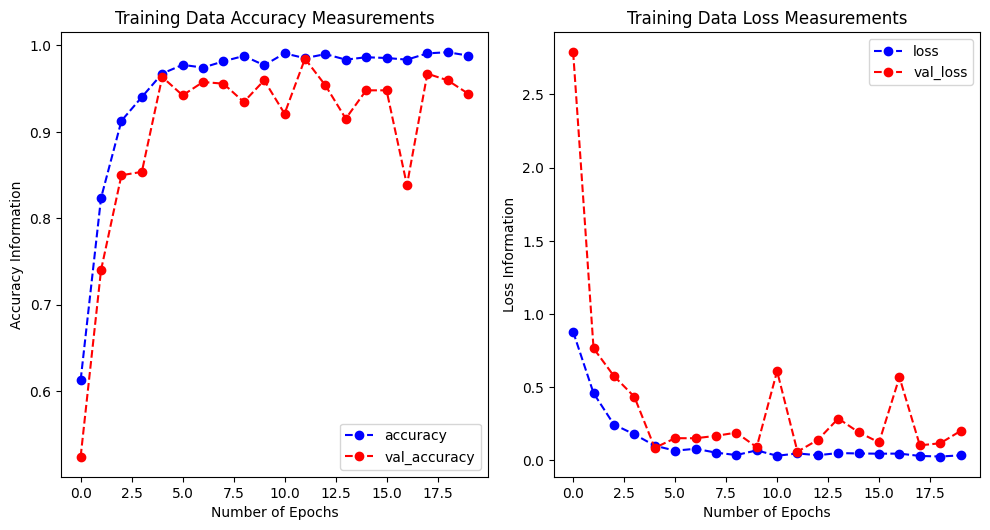

In [ ]:
accuracy_and_loss_Plot(history)